In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [1]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [3]:
data_dir = '/kaggle/input/bird-speciees-dataset/Bird Speciees Dataset'
filepaths, image_list, label_list = [], [], []

folders = os.listdir(data_dir)

for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        label_list.append(fold)
        
for file in filepaths:
    image = cv2.imread(file)
    image = img_to_array(image)
    image_list.append(image)
    
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(label_list, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [4]:
df

filepaths             labels
0    /kaggle/input/bird-speciees-dataset/Bird Speci...  CARMINE BEE-EATER
1    /kaggle/input/bird-speciees-dataset/Bird Speci...  CARMINE BEE-EATER
2    /kaggle/input/bird-speciees-dataset/Bird Speci...  CARMINE BEE-EATER
3    /kaggle/input/bird-speciees-dataset/Bird Speci...  CARMINE BEE-EATER
4    /kaggle/input/bird-speciees-dataset/Bird Speci...  CARMINE BEE-EATER
..                                                 ...                ...
806  /kaggle/input/bird-speciees-dataset/Bird Speci...           FLAMINGO
807  /kaggle/input/bird-speciees-dataset/Bird Speci...           FLAMINGO
808  /kaggle/input/bird-speciees-dataset/Bird Speci...           FLAMINGO
809  /kaggle/input/bird-speciees-dataset/Bird Speci...           FLAMINGO
810  /kaggle/input/bird-speciees-dataset/Bird Speci...           FLAMINGO

[811 rows x 2 columns]

In [6]:
image_list[0][12]

array([[135., 191., 246.],
       [122., 175., 232.],
       [112., 163., 225.],
       [115., 166., 228.],
       [122., 176., 237.],
       [131., 188., 249.],
       [121., 181., 241.],
       [ 93., 154., 216.],
       [104., 165., 229.],
       [119., 177., 242.],
       [133., 187., 250.],
       [143., 195., 255.],
       [150., 199., 255.],
       [149., 196., 248.],
       [158., 200., 253.],
       [156., 198., 251.],
       [153., 198., 249.],
       [153., 200., 251.],
       [153., 200., 251.],
       [154., 202., 250.],
       [154., 203., 249.],
       [154., 203., 249.],
       [157., 205., 253.],
       [155., 204., 254.],
       [147., 194., 248.],
       [130., 179., 235.],
       [117., 169., 222.],
       [ 97., 152., 203.],
       [ 65., 122., 173.],
       [ 58., 115., 166.],
       [ 73., 131., 183.],
       [107., 164., 216.],
       [124., 177., 227.],
       [142., 191., 239.],
       [158., 202., 249.],
       [167., 209., 254.],
       [173., 213., 255.],
 

In [7]:
df['labels'].value_counts()

labels
AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
Name: count, dtype: int64

In [8]:
# Storing number of classes
num_classes = len(df['labels'].unique())
num_classes

6

In [9]:
image_list[0].shape

(224, 224, 3)

In [10]:
# Checking labels shape 
label_list = np.array(label_list)
label_list.shape

(811,)

# Visualize bird Species

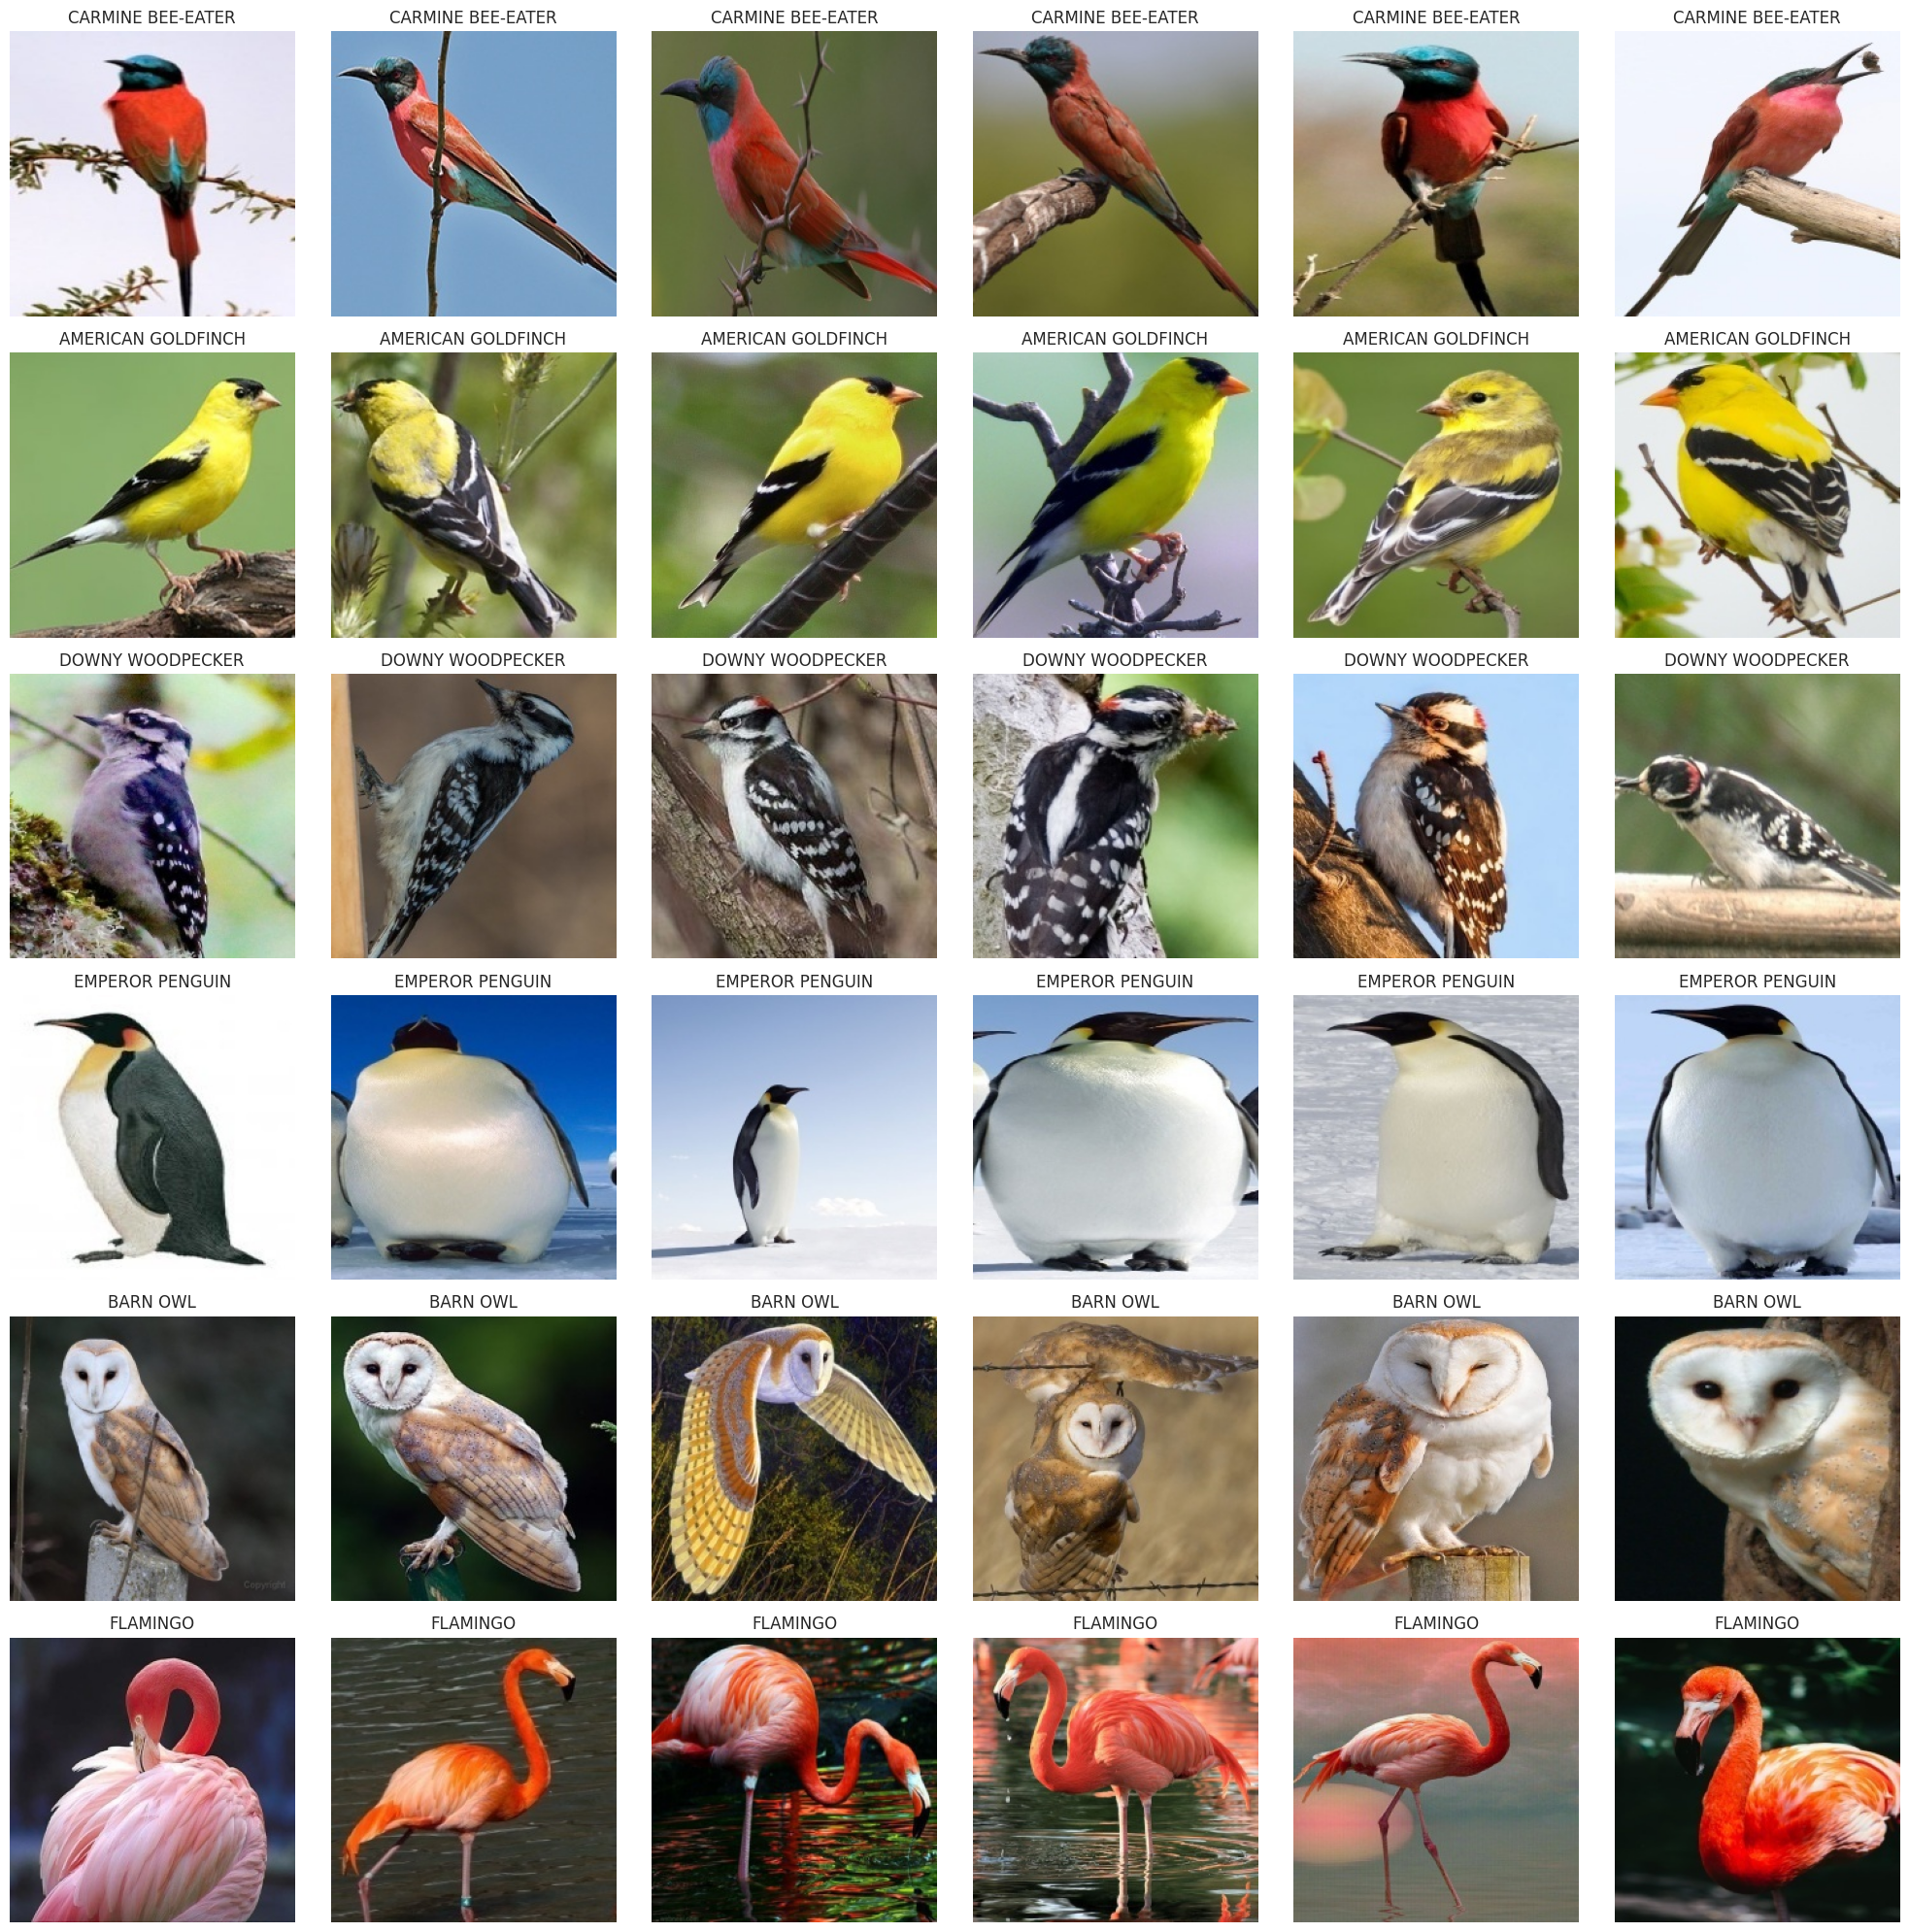

In [11]:
# Set the number of images to display per species
num_images = 6

# Get unique bird species labels
bird_species = df['labels'].unique()

# Set up the plot
plt.figure(figsize=(20, 20))

# Loop through each bird species
for idx, bird in enumerate(bird_species):
    # Filter the DataFrame to get file paths for this bird species
    bird_df = df[df['labels'] == bird].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(bird_df['filepaths'].values):
        plt.subplot(len(bird_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(bird)
        
# Show the plot
plt.tight_layout()
plt.show()

# Spliting the data into Training and testing

In [12]:
# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.3, shuffle=True, stratify=strat, random_state=123)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.5, shuffle=True, stratify=strat, random_state=123)

In [13]:
train_df

filepaths             labels
8    /kaggle/input/bird-speciees-dataset/Bird Speci...  CARMINE BEE-EATER
564  /kaggle/input/bird-speciees-dataset/Bird Speci...           BARN OWL
529  /kaggle/input/bird-speciees-dataset/Bird Speci...    EMPEROR PENGUIN
603  /kaggle/input/bird-speciees-dataset/Bird Speci...           BARN OWL
463  /kaggle/input/bird-speciees-dataset/Bird Speci...    EMPEROR PENGUIN
..                                                 ...                ...
93   /kaggle/input/bird-speciees-dataset/Bird Speci...  CARMINE BEE-EATER
648  /kaggle/input/bird-speciees-dataset/Bird Speci...           BARN OWL
639  /kaggle/input/bird-speciees-dataset/Bird Speci...           BARN OWL
580  /kaggle/input/bird-speciees-dataset/Bird Speci...           BARN OWL
66   /kaggle/input/bird-speciees-dataset/Bird Speci...  CARMINE BEE-EATER

[567 rows x 2 columns]

In [14]:
print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

Number of Training dataset: 567
Number of Validation dataset: 122
Number of Testing dataset: 122


# Create image data generator

In [15]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle= True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 567 validated image filenames belonging to 6 classes.
Found 122 validated image filenames belonging to 6 classes.
Found 122 validated image filenames belonging to 6 classes.


# ANN
##Build and Train ANN

In [16]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [17]:
def load_model():
    model = Sequential([
        Flatten(input_shape = img_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(class_count, activation='softmax')
    ])
    
    model.compile(Adamax(learning_rate=.0005), loss = 'categorical_crossentropy', metrics=['acc'])
    
    return model

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

plateau = ReduceLROnPlateau(
    patience=4,
    mode=min,
    monitor='val_loss',
    factor=.2,
    verbose=0
)

ann_model = load_model()
history = ann_model.fit(x= train_gen, verbose=1, validation_data=valid_gen,
                        shuffle=False, epochs=1000, callbacks=[early_stopping, plateau])

Epoch 1/1000


I0000 00:00:1730797724.074077     364 service.cc:145] XLA service 0x7edb14004390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730797724.074156     364 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


13/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.1776 - loss: 3044.0493

I0000 00:00:1730797725.573155     364 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - acc: 0.2197 - loss: 2059.9038 - val_acc: 0.2213 - val_loss: 875.5808 - learning_rate: 5.0000e-04
Epoch 2/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.4199 - loss: 578.5667 - val_acc: 0.4262 - val_loss: 573.3707 - learning_rate: 5.0000e-04
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.4643 - loss: 505.6636 - val_acc: 0.5328 - val_loss: 379.7398 - learning_rate: 5.0000e-04
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.4744 - loss: 450.6465 - val_acc: 0.5164 - val_loss: 349.7795 - learning_rate: 5.0000e-04
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.5702 - loss: 397.6557 - val_acc: 0.5574 - val_loss: 230.0365 - learning_rate: 5.0000e-04
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.6585 - loss: 181.1161 - val_acc: 0.5000 - val_loss: 313.6349 - learning_rate: 5.0000e-04
Epoch 7/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.6621 - loss: 152.4549 - val_acc: 0.5820 - va

# Display model performace

In [18]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

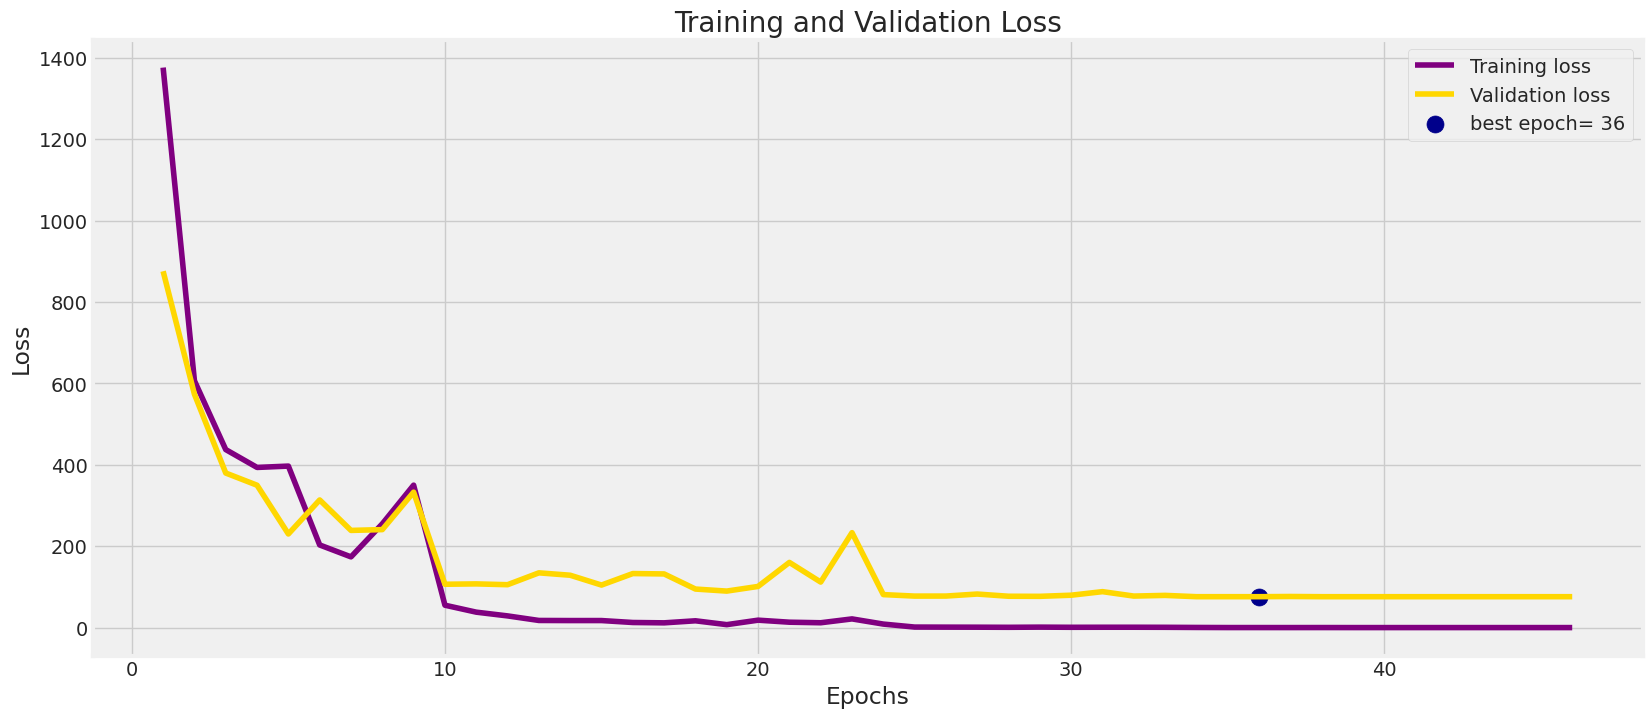

In [19]:
# Plot Training and Validation Loss
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show()

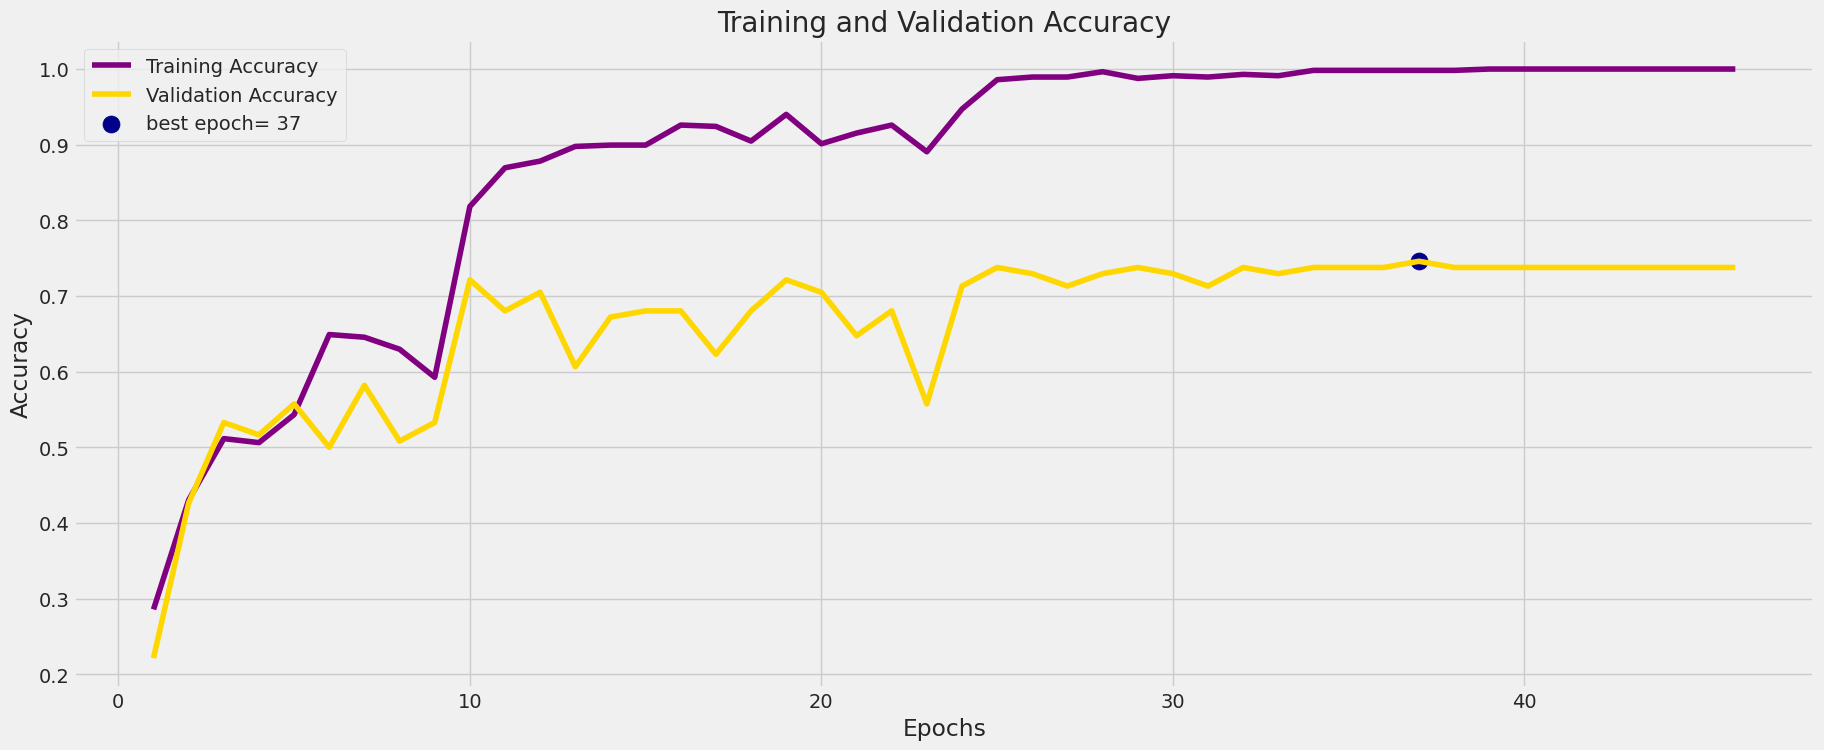

In [20]:
# Plot Training and Validation Accuracy
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# CNN

In [22]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [23]:
def load_model():
    model = Sequential([
        Conv2D(8, (3,3), activation='relu', padding='same', input_shape = img_shape),
        MaxPooling2D((3,3)),
        
        Conv2D(16, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        
        Conv2D(32, (3,3), activation='relu', padding='same'),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        
        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        
        Flatten(),

        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dense(class_count, activation='softmax')
    ])
    
    model.compile(Adamax(learning_rate=.0005), loss = 'categorical_crossentropy', metrics=['acc'])
    
    return model

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

plateau = ReduceLROnPlateau(
    patience=4,
    mode=min,
    monitor='val_loss',
    factor=.2,
    verbose=0
)

# CNN_model_checkpoint = ModelCheckpoint('/kaggle/working/CNN_best_model.keras', monitor='val_loss', 
#                                        mode=min, save_best_only=True)

cnn_model = load_model()
history = cnn_model.fit(x= train_gen, verbose=1, validation_data=valid_gen,
                        epochs=1000, callbacks=[early_stopping, plateau])

Epoch 1/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - acc: 0.2969 - loss: 1.9499 - val_acc: 0.6393 - val_loss: 1.1237 - learning_rate: 5.0000e-04
Epoch 2/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.7107 - loss: 0.8675 - val_acc: 0.6066 - val_loss: 0.9491 - learning_rate: 5.0000e-04
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.8128 - loss: 0.5253 - val_acc: 0.7459 - val_loss: 0.8187 - learning_rate: 5.0000e-04
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.8769 - loss: 0.3692 - val_acc: 0.8361 - val_loss: 0.5766 - learning_rate: 5.0000e-04
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9066 - loss: 0.2568 - val_acc: 0.7623 - val_loss: 0.6999 - learning_rate: 5.0000e-04
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9682 - loss: 0.1203 - val_acc: 0.7869 - val_loss: 0.6808 - learning_rate: 5.0000e-04
Epoch 7/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9589 - loss: 0.1236 - val_acc: 0.8525 - val_loss: 0.6208

In [24]:
# Save the model 
cnn_model.save('bird_Species.h5')

# Display model performance

In [25]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

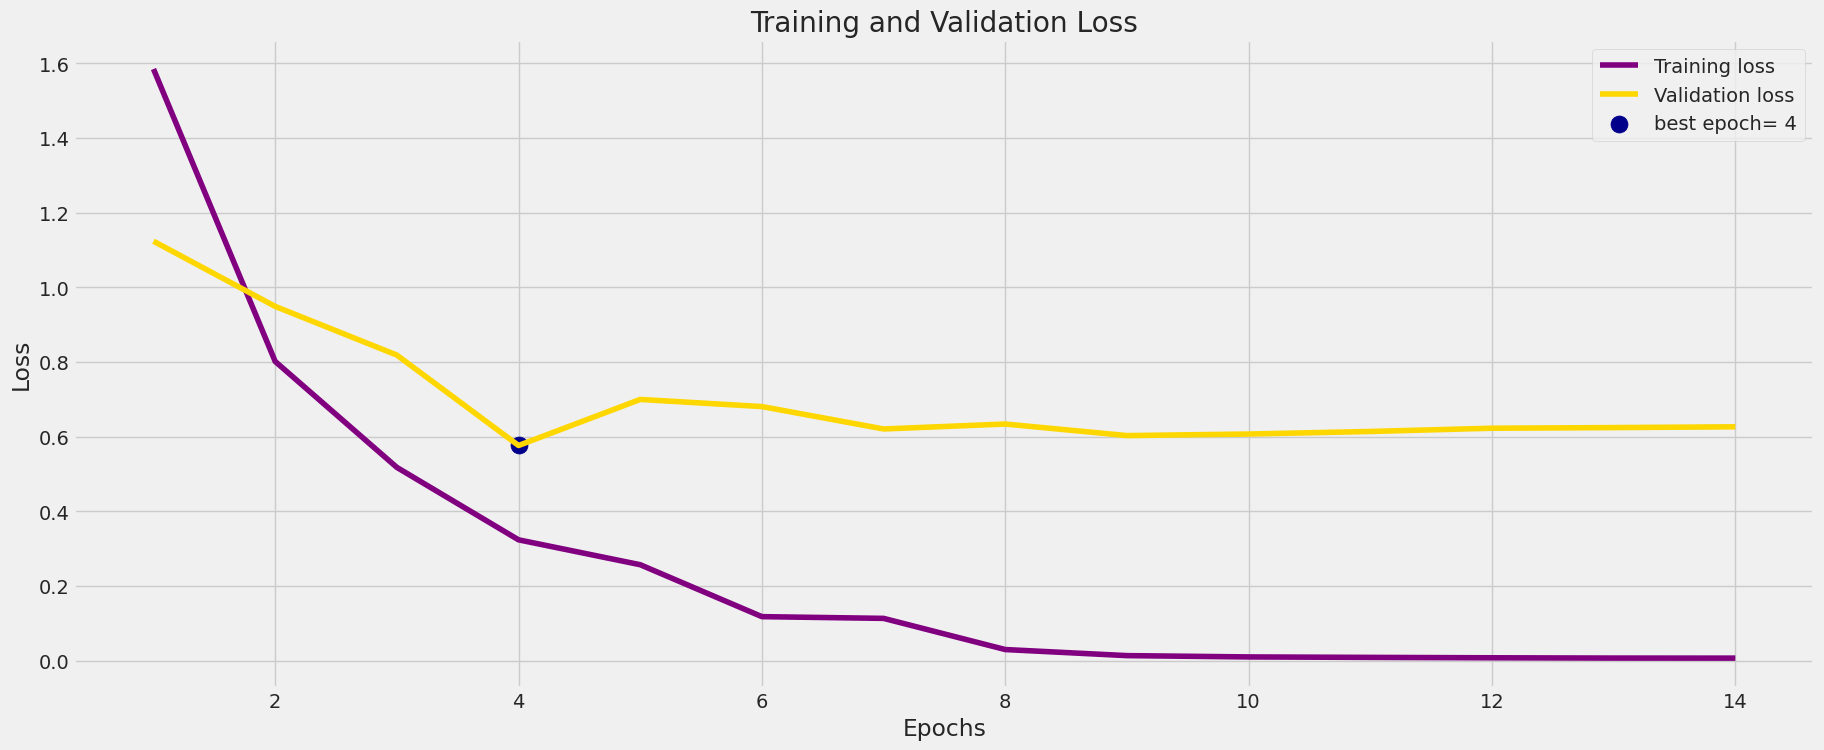

In [26]:
# Plot Training and Validation Loss
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show()

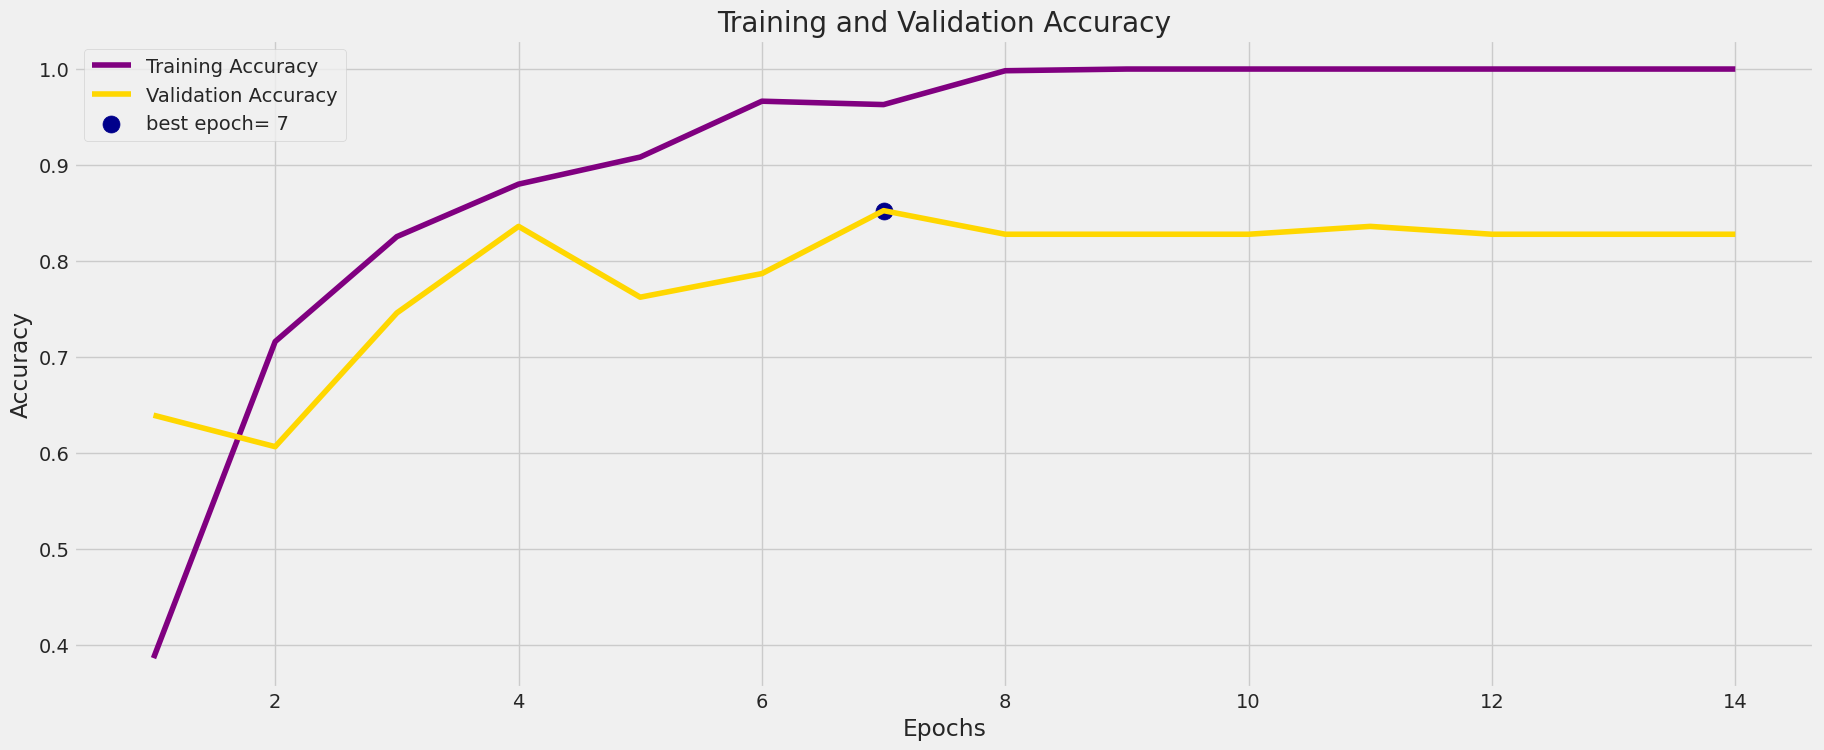

In [27]:
# Plot Training and Validation Accuracy
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Get Predictions

In [28]:
preds = cnn_model.predict(test_gen)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [29]:
y_pred = np.argmax(preds, axis=1)
y_pred

array([4, 3, 0, 0, 2, 0, 5, 3, 1, 1, 5, 3, 1, 0, 4, 1, 5, 2, 3, 1, 2, 3,
       4, 3, 4, 0, 1, 3, 2, 0, 2, 0, 4, 3, 2, 4, 5, 2, 0, 2, 3, 0, 5, 5,
       5, 4, 4, 5, 1, 3, 1, 3, 1, 0, 2, 4, 2, 3, 3, 2, 2, 2, 0, 0, 5, 0,
       2, 4, 0, 4, 2, 2, 5, 5, 0, 1, 2, 2, 4, 1, 1, 4, 2, 2, 4, 1, 0, 2,
       0, 3, 4, 0, 4, 0, 3, 0, 3, 5, 0, 4, 0, 3, 1, 4, 2, 3, 3, 0, 4, 3,
       1, 4, 2, 1, 1, 5, 3, 4, 5, 5, 3, 5])

In [30]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

In [31]:
g_dict

{'AMERICAN GOLDFINCH': 0,
 'BARN OWL': 1,
 'CARMINE BEE-EATER': 2,
 'DOWNY WOODPECKER': 3,
 'EMPEROR PENGUIN': 4,
 'FLAMINGO': 5}

In [32]:
classes

['AMERICAN GOLDFINCH',
 'BARN OWL',
 'CARMINE BEE-EATER',
 'DOWNY WOODPECKER',
 'EMPEROR PENGUIN',
 'FLAMINGO']

In [33]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[19,  1,  0,  0,  0,  1],
       [ 1, 13,  3,  2,  0,  1],
       [ 1,  1, 18,  0,  0,  0],
       [ 0,  0,  0, 19,  1,  0],
       [ 0,  0,  1,  0, 20,  0],
       [ 2,  2,  1,  1,  0, 14]])

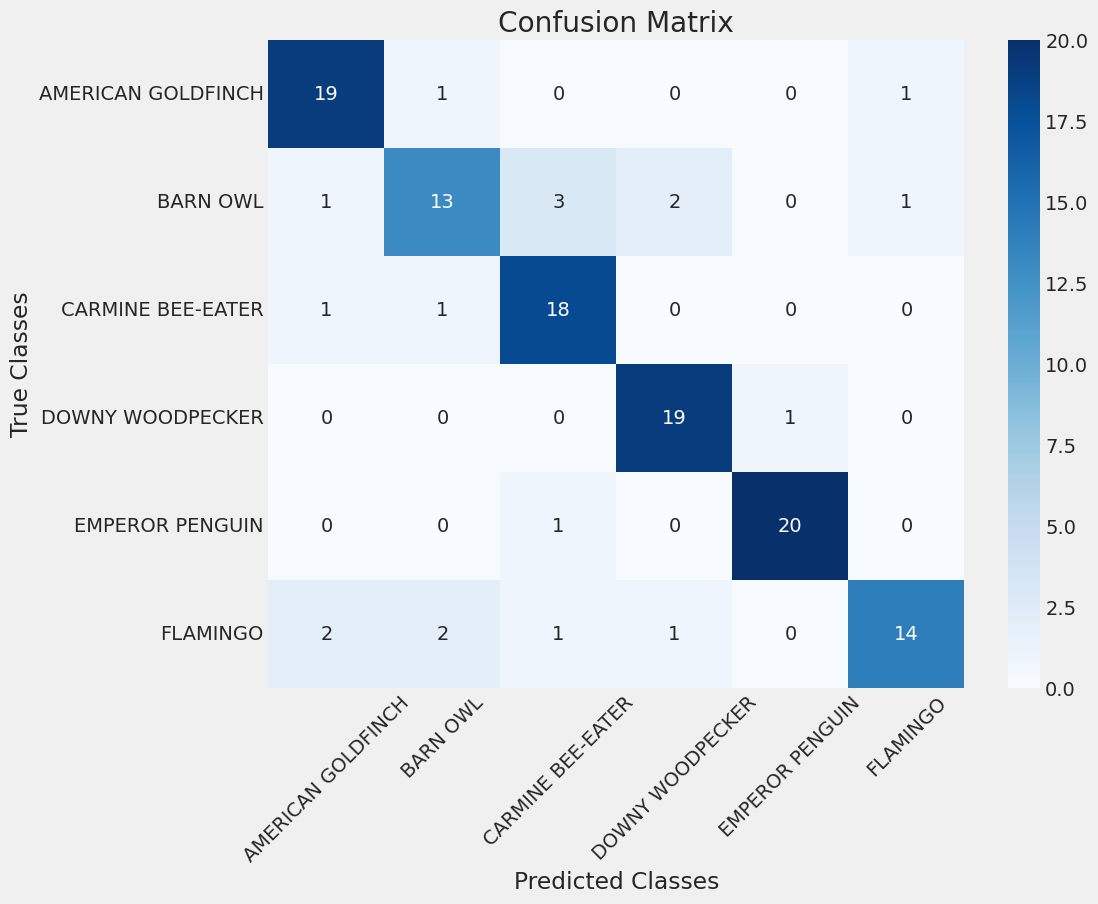

In [34]:
# Create a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)

# Add a title and label the axes
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')

# Modify the rotation of axis labels
plt.xticks(rotation=45)  # Rotation of x-axis labels
plt.yticks(rotation=0)   # Rotation of y-axis labels

plt.show()

In [35]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                    precision    recall  f1-score   support

AMERICAN GOLDFINCH       0.83      0.90      0.86        21
          BARN OWL       0.76      0.65      0.70        20
 CARMINE BEE-EATER       0.78      0.90      0.84        20
  DOWNY WOODPECKER       0.86      0.95      0.90        20
   EMPEROR PENGUIN       0.95      0.95      0.95        21
          FLAMINGO       0.88      0.70      0.78        20

          accuracy                           0.84       122
         macro avg       0.84      0.84      0.84       122
      weighted avg       0.84      0.84      0.84       122



# Evaluate Model

In [36]:
train_score = cnn_model.evaluate(train_gen, verbose= 1)
valid_score = cnn_model.evaluate(valid_gen, verbose= 1)
test_score = cnn_model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.9555 - loss: 0.1717
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8461 - loss: 0.5630
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8415 - loss: 0.4980
Train Loss:  0.16486358642578125
Train Accuracy:  0.9559082984924316
--------------------
Valid Loss:  0.5765560865402222
Valid Accuracy:  0.8360655903816223
--------------------
Test Loss:  0.5671535730361938
Test Accuracy:  0.8442623019218445


In [37]:
images, labels = next(test_gen)

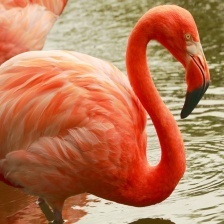

In [40]:
# Plotting image to compare
img = array_to_img(images[3])
img

In [41]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
print(classes)

['AMERICAN GOLDFINCH', 'BARN OWL', 'CARMINE BEE-EATER', 'DOWNY WOODPECKER', 'EMPEROR PENGUIN', 'FLAMINGO']


In [43]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",classes[np.argmax(labels[4])])
print("Predicted : ",classes[np.argmax(preds[3])])

Originally :  CARMINE BEE-EATER
Predicted :  AMERICAN GOLDFINCH
